### Prerequisits
This notebook uses basemap for interpolation. 

Installation can be done with conda:
```conda install basemap```

In [1]:
import numpy as np
from mpl_toolkits import basemap
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


Bad key "text.kerning_factor" on line 4 in
/home/angela/anaconda3/envs/coral_datadownload/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def load_colormap(filename):
    """Load a colormap defined in a text file
    filename is the .txt file name located in the
    data/path, not the full path.
    list_available_colormaps() lists the available color tables
    """
    try:
        color_map_values = pd.read_csv(filename).to_numpy()/255.
        colormap = ListedColormap(color_map_values)
    except IOError:
        print(f"Cannot load colormap {filename}")
        raise
    colormap.set_bad("gray") # color of missing pixels
    colormap.set_under("white") # color of background, necessary if you want to use
    # this colormap directly with hp.mollview(m, cmap=colormap)
    # healpy tutorial see:https://healpy.readthedocs.io/en/latest/tutorial.html
    return colormap

### Specify Location
Provide the path to the netCDF4 file you want to analyse. It should contain results of the sedement or other algorithms.

In [5]:
l2w = '/home/angela/m3/tutorials/tmp/S2A_MSI_2020_03_21_16_05_11_T17PKK_L2W.nc'

In [6]:
rootgrp = Dataset(l2w, "a")

In [7]:
print(rootgrp.variables)

{'lon': <class 'netCDF4._netCDF4.Variable'>
float32 lon(y, x)
    standard_name: longitude
    units: degree_east
unlimited dimensions: 
current shape = (2946, 2718)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lat': <class 'netCDF4._netCDF4.Variable'>
float32 lat(y, x)
    standard_name: latitude
    units: degree_north
unlimited dimensions: 
current shape = (2946, 2718)
filling on, default _FillValue of 9.969209968386869e+36 used, 'l2_flags': <class 'netCDF4._netCDF4.Variable'>
int32 l2_flags(y, x)
    standard_name: l2_flags
    units: 1
unlimited dimensions: 
current shape = (2946, 2718)
filling on, default _FillValue of -2147483647 used, 'spm_nechad2016': <class 'netCDF4._netCDF4.Variable'>
float32 spm_nechad2016(y, x)
    algorithm: 2016 calibration
    title: Nechad SPM
    standard_name: spm
    long_name: Suspended Particulate Matter
    units: g m^-3
    reference: Nechad et al. 2010
    wave: 665.0
    A_SPM: 342.1
    C_SPM: 0.19563
unlimited dimensions: 


In [8]:
print(rootgrp.variables['lon'])

<class 'netCDF4._netCDF4.Variable'>
float32 lon(y, x)
    standard_name: longitude
    units: degree_east
unlimited dimensions: 
current shape = (2946, 2718)
filling on, default _FillValue of 9.969209968386869e+36 used


#### Print values
Print the first 5 data elements of the latitude variable

In [10]:
lats = rootgrp.variables['lat'][:]
print(f"min: {np.nanmin(lats)}, max: {np.nanmax(lats)}")
lats[0:5,0:5].data

min: 8.47068977355957, max: 8.738358497619629


array([[8.736822 , 8.736823 , 8.736823 , 8.736824 , 8.736825 ],
       [8.736732 , 8.7367325, 8.736733 , 8.736733 , 8.736734 ],
       [8.736642 , 8.736642 , 8.736643 , 8.736644 , 8.736644 ],
       [8.736551 , 8.736552 , 8.736552 , 8.736553 , 8.736553 ],
       [8.736461 , 8.736462 , 8.736462 , 8.736463 , 8.736464 ]],
      dtype=float32)

### Interpolation - Experimental !!! Use following cell instead!!!

In [22]:
with Dataset(l2w, mode='r') as fh:
    lons = fh.variables['lon'][:]
    lats = fh.variables['lat'][:]
    spms = fh.variables['spm_nechad2016'][:].squeeze()

                        
#lons_sub, lats_sub = np.meshgrid(lons[::16,::16], lats[::16,::16])
#lons_sub, lats_sub = lons[::16,::16], lats[::16,::16]

#lons_sub, lats_sub = lons[::4], lats[::4]
#lons_sub, lats_sub = np.meshgrid(lons[::16,::16], lats[::16,::16])



#print(f"lons: {lons.shape} resampled to {lons_sub.shape}")
#print(f"lons: {lons.shape}, lats:{lats.shape}, spms:{spms.shape}")
 
# linspace is similar to range, returns a sequence in range (from, to, numberOfVals)
nlons = 100
nlats = 110
lons_sub = np.linspace(np.nanmin(lons), np.nanmax(lons), nlons)
lats_sub = np.linspace(np.nanmin(lats), np.nanmax(lats), nlats)

#why use meshgrid.see:
#https://sourceforge.net/p/matplotlib/mailman/message/24637586/
lons_new, lats_new = np.meshgrid(lons_sub, lats_sub)

print(lons_new.shape)


spm_coarse = basemap.interp(spms, np.sort(lons[0,:]), np.sort(lats[:,0]), lons_new, lats_new, order=0)

print(f"min: {np.nanmin(spm_coarse)}, max: {np.nanmax(spm_coarse)}, mean: {np.nanmean(spm_coarse)}")

(100, 100)
min: -1.0284855365753174, max: 27.592741012573242, mean: 2.363090753555298


### Interpolation - preferred version
These steps are performed:
1. load the data from the file with the given path, longutude and latitude from 
2. Sort longutude and latitude. This is a prerequisite for basemap.interp
3. Perform the interpolation with nearest neighbor method. Reduce with factor twenty by choosing every 20th element form the sorted longuitudes and latitudes.

In [21]:
with Dataset(l2w, mode='r') as fh:
    lon = fh.variables['lon'][:]
    lat = fh.variables['lat'][:]
    spm = fh.variables['spm_nechad2016'][:].squeeze()

lat_sorted = np.sort(lat, axis=0)
lon_sorted = np.sort(lon, axis=0)

lon_new, lat_new = np.meshgrid(lon_sorted[0,:][::20], lat_sorted[:,0][::20])

print(lat_new.shape)
print(lon_new.shape)

spm_coarse = basemap.interp(spm, lon_sorted[0,:], lat_sorted[:,0], lon_new, lat_new, order=1)

print(f"min: {np.nanmin(spm_coarse)}, max: {np.nanmax(spm_coarse)}, mean: {np.nanmean(spm_coarse)}")

(148, 136)
(148, 136)
min: -1.3056745529174805, max: 24.573102951049805, mean: 2.2961606979370117


### Plotting
Plot the interpolated data using the planck parchment colormap.

In [22]:
cmp = load_colormap('data/planck_parchment_rgb.csv')

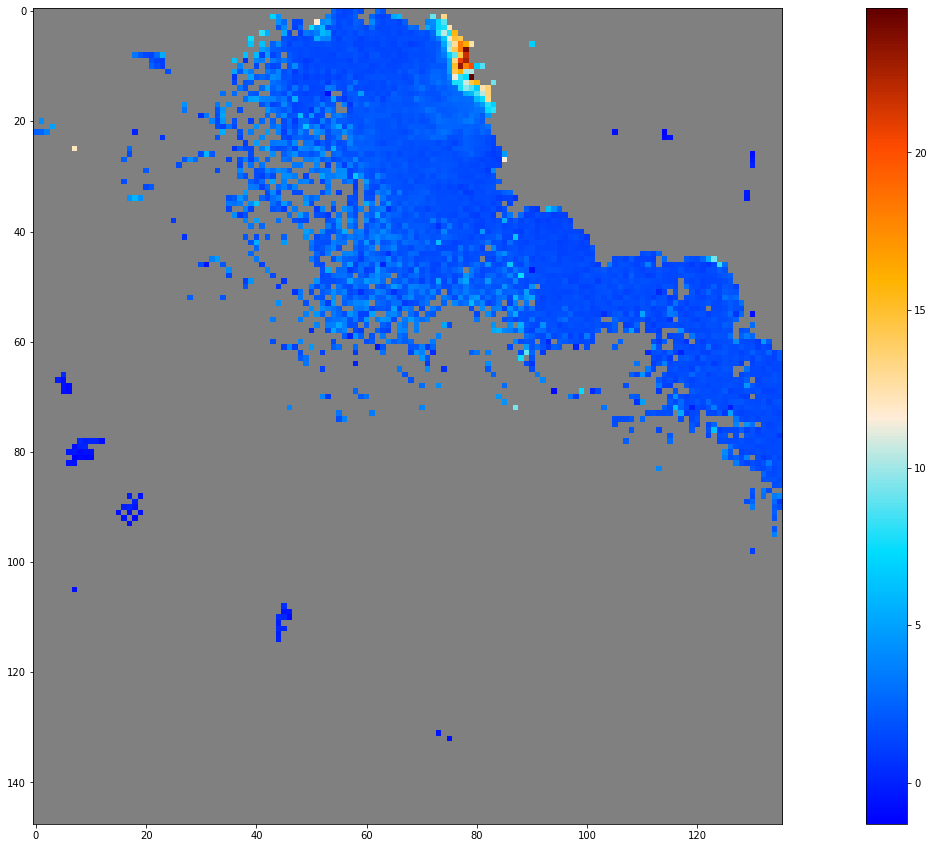

In [23]:
from matplotlib.colors import Normalize, LogNorm 
# Plot the green band using a non-default color ramp & a color bar
# see also: https://matplotlib.org/users/colormaps.html
plt.rcParams["figure.figsize"] = (30,15)
fig = plt.imshow(spm_coarse)
#vmin=Z.min(), vmax=Z.max2
#fig = plt.imshow(data, norm=Normalize(1,100))
fig.set_cmap(cmp)

plt.colorbar()
plt.show()